In [1]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [9]:
data_path = "/content/drive/MyDrive/DL-Final Exam/emotions_dataset.csv"
data=pd.read_csv(data_path)
data.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


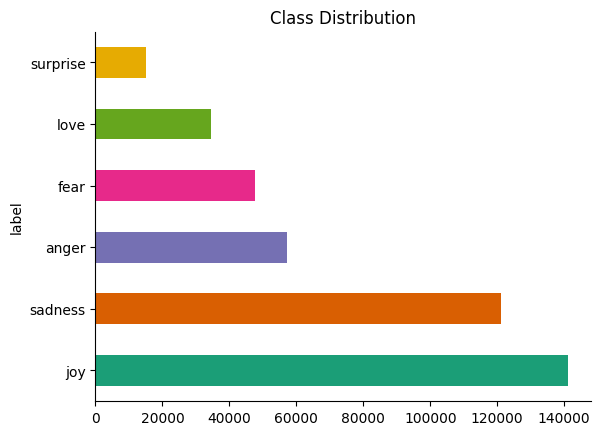

In [10]:
# Display the labels distribution
data['label'].value_counts().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.title("Class Distribution")
plt.show()

In [11]:
# Set seed for reproducibility
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [12]:
# Text Preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    text = ' '.join([lemmatizer.lemmatize(word) for word in words if word not in stop_words])
    return text

data['text'] = data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

sequences = tokenizer.texts_to_sequences(data['text'])
max_length = int(np.percentile([len(seq) for seq in sequences], 90))
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [14]:
# Label Encoding
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
labels = tf.keras.utils.to_categorical(data['label'])

In [15]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)


In [16]:
# Define the Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(labels.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [18]:
# Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)



Epoch 1/15
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 450s 226ms/step - accuracy: 0.7591 - loss: 0.6224 - val_accuracy: 0.9233 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 2/15
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 500s 225ms/step - accuracy: 0.9290 - loss: 0.1430 - val_accuracy: 0.9237 - val_loss: 0.1478 - learning_rate: 9.0000e-04
Epoch 3/15
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 444s 227ms/step - accuracy: 0.9353 - loss: 0.1188 - val_accuracy: 0.9233 - val_loss: 0.1541 - learning_rate: 8.1000e-04
Epoch 4/15
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 506s 230ms/step - accuracy: 0.9392 - loss: 0.1051 - val_accuracy: 0.9237 - val_loss: 0.1740 - learning_rate: 7.2900e-04
Epoch 5/15
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 442s 226ms/step - accuracy: 0.9414 - loss: 0.0967 - val_accuracy: 0.9211 - val_loss: 0.1963 - learning_rate: 6.5610e-04


In [19]:
## Evaluate Model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.9234 - loss: 0.1472
Validation Loss: 0.14781075716018677
Validation Accuracy: 0.9237422347068787


In [20]:
# Classification Report
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

2606/2606 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.94      0.92     11469
        fear       0.96      0.81      0.88      9529
         joy       0.91      0.98      0.94     28226
        love       0.95      0.71      0.81      6906
     sadness       0.95      0.97      0.96     24247
    surprise       0.75      0.90      0.82      2985

    accuracy                           0.92     83362
   macro avg       0.91      0.88      0.89     83362
weighted avg       0.93      0.92      0.92     83362



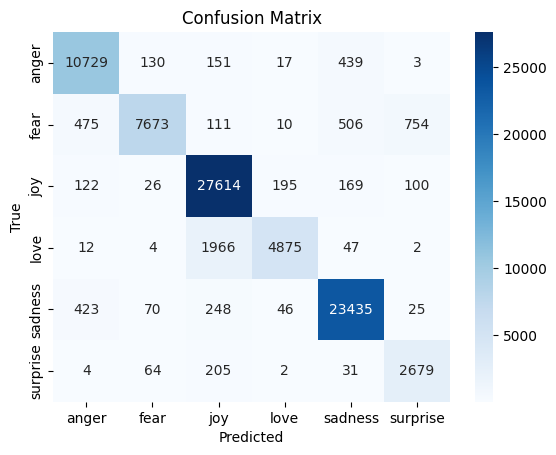

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

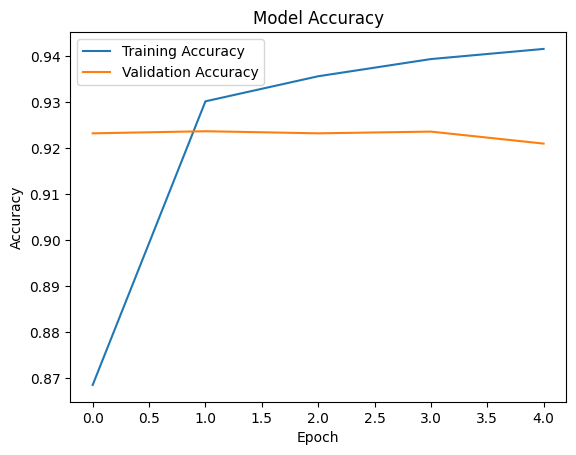

In [22]:
# Visualize Training History
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


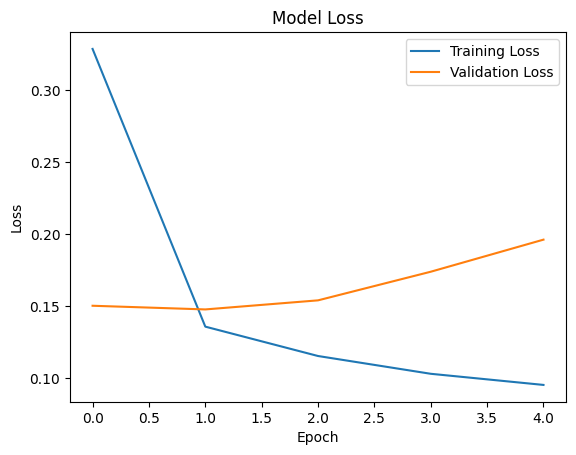

In [23]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Save the Model
model.save("optimized_emotion_model.h5")

# Save Tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [25]:
# Example Predictions
example_texts = ["I am so happy today!", "I feel very frustrated and sad.", "Just an ordinary day."]
example_sequences = tokenizer.texts_to_sequences([clean_text(text) for text in example_texts])
example_padded = pad_sequences(example_sequences, maxlen=max_length, padding='post')
example_predictions = model.predict(example_padded)
example_classes = np.argmax(example_predictions, axis=1)
example_labels = label_encoder.inverse_transform(example_classes)

for text, label in zip(example_texts, example_labels):
    print(f"Text: {text}")
    print(f"Predicted Emotion: {label}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: I am so happy today!
Predicted Emotion: joy
--------------------------------------------------
Text: I feel very frustrated and sad.
Predicted Emotion: anger
--------------------------------------------------
Text: Just an ordinary day.
Predicted Emotion: sadness
--------------------------------------------------
